# DQN Part1
- 발표자 : 최찬혁

This code is a code that applies DQN(Naive DQN, DQN and Double DQN) algorithms to environment "Cartpole-v1" from OpenAI gym.

## Deep Reinforcement Learning(DRL)

All the codes we did in the past were related to reinforcement learning ($Q$-learning, SARSA etc.).

From today, we will learn the code related to deep reinforcement learning.

Deep Reinforcement Learning = Deep Learning + Reinforcement Learning.

Deep Learning means that we will approximate state-action function or policy by deep neural networks.

## Naive DQN
The DQN algorithm is a deep learning version of Q-learning.

![Q_learning](./Q-Learning_Algorithm.JPG)

Naive DQN treats $r_{t+1} + \gamma \underset{a}\max Q\left( s_{t+1} , a ; \theta \right)$ as a target.

It means that the loss function will be $L\left( \theta \right) = \left[ r_{t+1} + \gamma \underset{a}\max Q\left( s_{t+1} , a ; \theta \right) - Q \left( s_{t} , a_{t} ; \theta \right) \right] ^{2}$

In [1]:
!pip install gym --upgrade
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import random
from collections import deque

In [2]:
learning_rate = 0.005
GAMMA = 0.95
epsilon = 1.0

In [3]:
env1 = gym.make("CartPole-v1")

In [4]:
class NAIVE_DQN:
    def __init__(self, state_dim, aciton_dim):
        self.state_dim = state_dim
        self.action_dim = aciton_dim
        self.epsilon = epsilon

        self.model = self.nn_model()

    def nn_model(self):
        model = tf.keras.Sequential(
            [
                Input((self.state_dim,)),
                Dense(8, activation="relu"),
                Dense(8, activation="relu"),
                Dense(self.action_dim),
            ]
        )
        model.compile(loss="mse", optimizer=Adam(learning_rate))
        return model

    def predict(self, state):
        return self.model.predict(state, verbose =0)

    def get_action(self, state):
        state = np.reshape(state, [1, self.state_dim])
        q_value = self.predict(state)[0]
        if np.random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        return np.argmax(q_value)

    def train(self, states, targets):
        self.model.fit(states, targets, epochs=1, verbose = 0)

In [5]:
class Agent_NAIVE_DQN:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n

        self.model = NAIVE_DQN(self.state_dim, self.action_dim)

    def train(self, max_episodes=1000):
        episode_rewards = []        
        for ep in range(max_episodes):
            done, episode_reward = False, 0
            observation,_ = self.env.reset()
            self.model.epsilon = 1.0/(1.0+(ep*0.1))
            while not done:
                action = self.model.get_action(observation)
                next_observation, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                target = self.model.predict(np.reshape(observation,(1,-1)))
                target[0][action] = (GAMMA * self.model.predict(np.reshape(next_observation,(1,-1))).max(axis=1)) + reward
                self.model.train(states = np.reshape(observation,(1,-1)), targets = target)
                episode_reward += reward
                observation = next_observation

            print(f"Episode#{ep} Reward:{episode_reward}")
            episode_rewards.append(episode_reward)
        
        plt.plot(episode_rewards)
        plt.show()
        return episode_rewards

In [6]:
agent1 = Agent_NAIVE_DQN(env1)

Episode#0 Reward:13.0
Episode#1 Reward:12.0
Episode#2 Reward:10.0
Episode#3 Reward:17.0
Episode#4 Reward:15.0
Episode#5 Reward:27.0
Episode#6 Reward:15.0
Episode#7 Reward:29.0
Episode#8 Reward:22.0
Episode#9 Reward:14.0
Episode#10 Reward:20.0
Episode#11 Reward:11.0
Episode#12 Reward:10.0
Episode#13 Reward:9.0
Episode#14 Reward:21.0
Episode#15 Reward:18.0
Episode#16 Reward:10.0
Episode#17 Reward:12.0
Episode#18 Reward:9.0
Episode#19 Reward:12.0
Episode#20 Reward:14.0
Episode#21 Reward:12.0
Episode#22 Reward:14.0
Episode#23 Reward:12.0
Episode#24 Reward:11.0
Episode#25 Reward:10.0
Episode#26 Reward:17.0
Episode#27 Reward:9.0
Episode#28 Reward:10.0
Episode#29 Reward:9.0
Episode#30 Reward:11.0
Episode#31 Reward:11.0
Episode#32 Reward:9.0
Episode#33 Reward:12.0
Episode#34 Reward:15.0
Episode#35 Reward:10.0
Episode#36 Reward:11.0
Episode#37 Reward:10.0
Episode#38 Reward:9.0
Episode#39 Reward:9.0
Episode#40 Reward:11.0
Episode#41 Reward:10.0
Episode#42 Reward:10.0
Episode#43 Reward:8.0
Episod

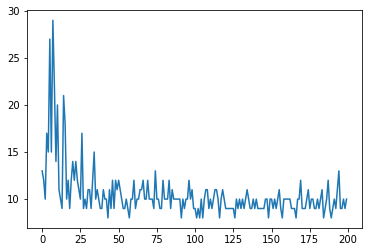

In [7]:
ep_rewards_NAIVE = agent1.train(max_episodes=200)
np.save("NAIVE_result.npy", np.array(ep_rewards_NAIVE))

We can see that it doesn't converge.

There are some problems in this algorithm.

- temporal correlations between samples

- non-stationary targets

## DQN

To overcome these problems we use experience replay(Replay buffer) and target network

- To overcome temporal correlations between samples problem, use experience replay(Replay buffer).

- To overcome non-stationary targets, use target newtork.

![DQN_Algorithm](./DQN_Algorithm.JPG)

In [8]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

import random
from collections import deque

In [9]:
learning_rate = 0.005
GAMMA = 0.95
epsilon = 1.0

buffer_capacity = 10000
n_sample = 128
synchronize_period = 10 # The period of reset target network to behavior network

In [10]:
env2 = gym.make("CartPole-v1")

In [11]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])

    def sample(self):
        sample = random.sample(self.buffer, n_sample)
        states, actions, rewards, next_states, done = map(np.asarray, zip(*sample))
        states = np.array(states).reshape(n_sample, -1)
        next_states = np.array(next_states).reshape(n_sample, -1)
        return states, actions, rewards, next_states, done

    def size(self):
        return len(self.buffer)

In [12]:
class DQN:
    def __init__(self, state_dim, aciton_dim):
        self.state_dim = state_dim
        self.action_dim = aciton_dim
        self.epsilon = epsilon

        self.model = self.nn_model()

    def nn_model(self):
        model = tf.keras.Sequential(
            [
                Input((self.state_dim,)),
                Dense(8, activation="relu"),
                Dense(8, activation="relu"),
                Dense(self.action_dim),
            ]
        )
        model.compile(loss="mse", optimizer=Adam(learning_rate))
        return model

    def predict(self, state):
        return self.model.predict(state, verbose = 0)

    def get_action(self, state):
        state = np.reshape(state, [1, self.state_dim])
        q_value = self.predict(state)[0]
        if np.random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        return np.argmax(q_value)

    def train(self, states, targets):
        self.model.fit(states, targets, epochs=1, verbose = 0)

In [13]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n

        self.model = DQN(self.state_dim, self.action_dim)        # Behavior network
        self.target_model = DQN(self.state_dim, self.action_dim) # Target network
        self.update_target()

        self.buffer = ReplayBuffer(buffer_capacity)

    def update_target(self):
        weights = self.model.model.get_weights()
        self.target_model.model.set_weights(weights)

    def replay_experience(self):
        states, actions, rewards, next_states, done = self.buffer.sample()
        targets = self.model.predict(states)
        next_q_values = self.target_model.predict(next_states).max(axis=1)
        targets[range(n_sample), actions] = (
            rewards + (1 - done) * next_q_values * GAMMA
        )
        self.model.train(states, targets)

    def train(self, max_episodes=1000):
        episode_rewards = []
        for ep in range(max_episodes):
            done, episode_reward = False, 0
            self.model.epsilon = 1.0/(1.0+(ep*0.1))
            timestep = 0
            observation, _ = self.env.reset()
            while not done:
                action = self.model.get_action(observation)
                timestep = timestep + 1
                next_observation, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.buffer.store(
                    observation, action, reward * 0.01, next_observation, done
                )
                episode_reward += reward
                observation = next_observation
            
                if self.buffer.size() >= n_sample:
                    self.replay_experience()
            
                if (timestep % synchronize_period) == 0:
                    self.update_target()
            print(f"Episode#{ep} Reward:{episode_reward}")
            
            episode_rewards.append(episode_reward)
        
        plt.plot(episode_rewards)
        plt.show()
        return episode_rewards


In [14]:
agent2 = Agent(env2)

Episode#0 Reward:30.0
Episode#1 Reward:15.0
Episode#2 Reward:30.0
Episode#3 Reward:10.0
Episode#4 Reward:39.0
Episode#5 Reward:15.0
Episode#6 Reward:12.0
Episode#7 Reward:11.0
Episode#8 Reward:14.0
Episode#9 Reward:16.0
Episode#10 Reward:21.0
Episode#11 Reward:48.0
Episode#12 Reward:39.0
Episode#13 Reward:22.0
Episode#14 Reward:58.0
Episode#15 Reward:29.0
Episode#16 Reward:60.0
Episode#17 Reward:34.0
Episode#18 Reward:170.0
Episode#19 Reward:32.0
Episode#20 Reward:371.0
Episode#21 Reward:79.0
Episode#22 Reward:128.0
Episode#23 Reward:158.0
Episode#24 Reward:88.0
Episode#25 Reward:133.0
Episode#26 Reward:193.0
Episode#27 Reward:30.0
Episode#28 Reward:48.0
Episode#29 Reward:65.0
Episode#30 Reward:136.0
Episode#31 Reward:130.0
Episode#32 Reward:11.0
Episode#33 Reward:119.0
Episode#34 Reward:72.0
Episode#35 Reward:127.0
Episode#36 Reward:77.0
Episode#37 Reward:56.0
Episode#38 Reward:192.0
Episode#39 Reward:123.0
Episode#40 Reward:152.0
Episode#41 Reward:103.0
Episode#42 Reward:123.0
Episod

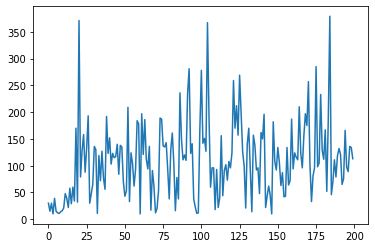

In [15]:
ep_rewards_DQN = agent2.train(max_episodes=200)
np.save("DQN_result.npy",np.array(ep_rewards_DQN))

## Double DQN
Because of max operator, Q-learning tends to have overestimated $Q\left( s, a\right)$.

To overcome this problem, we use Double Q-learning.

So there is an adaptation to DQN towards Double Q-learning to reduce overestimations which is called Double DQN.

Followings are loss function of DQN and Double DQN algorithms.

![loss functions](./Lossfunctions.JPG)

It means that there is a little change from DQN code.

In [16]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

import random
from collections import deque

In [17]:
learning_rate = 0.005
GAMMA = 0.95
epsilon = 1.0

buffer_capacity = 10000
n_sample = 128
synchronize_period = 10 # The period of reset target network to behavior network

In [18]:
env3 = gym.make("CartPole-v1")

In [19]:
class D_ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])

    def sample(self):
        sample = random.sample(self.buffer, n_sample)
        states, actions, rewards, next_states, done = map(np.asarray, zip(*sample))
        states = np.array(states).reshape(n_sample, -1)
        next_states = np.array(next_states).reshape(n_sample, -1)
        return states, actions, rewards, next_states, done

    def size(self):
        return len(self.buffer)

In [20]:
class DOUBLE_DQN:
    def __init__(self, state_dim, aciton_dim):
        self.state_dim = state_dim
        self.action_dim = aciton_dim
        self.epsilon = epsilon

        self.model = self.nn_model()

    def nn_model(self):
        model = tf.keras.Sequential(
            [
                Input((self.state_dim,)),
                Dense(8, activation="relu"),
                Dense(8, activation="relu"),
                Dense(self.action_dim),
            ]
        )
        model.compile(loss="mse", optimizer=Adam(learning_rate))
        return model

    def predict(self, state):
        return self.model.predict(state, verbose = 0)

    def get_action(self, state):
        state = np.reshape(state, [1, self.state_dim])
        q_value = self.predict(state)[0]
        if np.random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        return np.argmax(q_value)

    def train(self, states, targets):
        self.model.fit(states, targets, epochs=1, verbose = 0)

In [21]:
class D_Agent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n

        self.model = DOUBLE_DQN(self.state_dim, self.action_dim)        # Behavior network
        self.target_model = DOUBLE_DQN(self.state_dim, self.action_dim) # Target network
        self.update_target()

        self.buffer = D_ReplayBuffer(buffer_capacity)

    def update_target(self):
        weights = self.model.model.get_weights()
        self.target_model.model.set_weights(weights)

    def replay_experience(self):
        states, actions, rewards, next_states, done = self.buffer.sample()
        targets = self.model.predict(states)
        next_q_values = self.target_model.predict(next_states)[
            range(n_sample),
            np.argmax(self.model.predict(next_states), axis=1)
        ]
        targets[range(n_sample), actions] = (
            rewards + (1 - done) * next_q_values * GAMMA
        )
        self.model.train(states, targets)

    def train(self, max_episodes=1000):
        episode_rewards = []
        for ep in range(max_episodes):
            done, episode_reward = False, 0
            timestep = 0
            self.model.epsilon = 1.0/(1.0+(ep*0.1))
            observation, _ = self.env.reset()
            while not done:
                action = self.model.get_action(observation)
                timestep = timestep + 1
                next_observation, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.buffer.store(
                    observation, action, reward * 0.01, next_observation, done
                )
                episode_reward += reward
                observation = next_observation
            
                if self.buffer.size() >= n_sample:
                    self.replay_experience()
            
                if (timestep % synchronize_period) == 0:
                    self.update_target()
            print(f"Episode#{ep} Reward:{episode_reward}")
            
            episode_rewards.append(episode_reward)
        
        plt.plot(episode_rewards)
        plt.show()
        return episode_rewards


In [22]:
agent3 = D_Agent(env3)

Episode#0 Reward:11.0
Episode#1 Reward:43.0
Episode#2 Reward:20.0
Episode#3 Reward:19.0
Episode#4 Reward:39.0
Episode#5 Reward:21.0
Episode#6 Reward:11.0
Episode#7 Reward:10.0
Episode#8 Reward:15.0
Episode#9 Reward:12.0
Episode#10 Reward:9.0
Episode#11 Reward:15.0
Episode#12 Reward:25.0
Episode#13 Reward:13.0
Episode#14 Reward:35.0
Episode#15 Reward:18.0
Episode#16 Reward:13.0
Episode#17 Reward:12.0
Episode#18 Reward:12.0
Episode#19 Reward:26.0
Episode#20 Reward:86.0
Episode#21 Reward:33.0
Episode#22 Reward:93.0
Episode#23 Reward:51.0
Episode#24 Reward:140.0
Episode#25 Reward:93.0
Episode#26 Reward:500.0
Episode#27 Reward:172.0
Episode#28 Reward:217.0
Episode#29 Reward:230.0
Episode#30 Reward:438.0
Episode#31 Reward:221.0
Episode#32 Reward:242.0
Episode#33 Reward:213.0
Episode#34 Reward:104.0
Episode#35 Reward:252.0
Episode#36 Reward:179.0
Episode#37 Reward:107.0
Episode#38 Reward:168.0
Episode#39 Reward:157.0
Episode#40 Reward:414.0
Episode#41 Reward:174.0
Episode#42 Reward:167.0
Epis

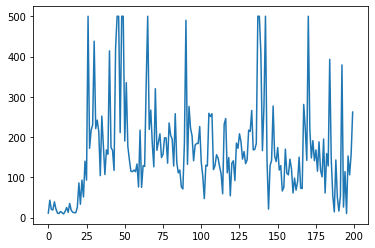

In [23]:
ep_rewards_DOUBLE_DQN = agent3.train(max_episodes=200)
np.save("DOUBLEDQN_result.npy", np.array(ep_rewards_DOUBLE_DQN))

## Compare Naive DQN vs DQN
We will plot average return of 10 episodes for Naive DQN, DQN and Double DQN

In [24]:
naive_average = np.zeros(20)
normal_average = np.zeros(20)
double_average = np.zeros(20)

for i in range(20):
    tmp1 = ep_rewards_NAIVE[10*i:10*i+10]
    naive_average[i] = sum(tmp1) / 10
    
    tmp2 = ep_rewards_DQN[10*i:10*i+10]
    normal_average[i] = sum(tmp2) / 10
    
    tmp3 = ep_rewards_DOUBLE_DQN[10*i:10*i+10]
    double_average[i] = sum(tmp3) / 10

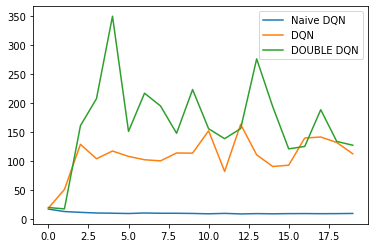

In [25]:
plt.plot(naive_average, label = 'Naive DQN')
plt.plot(normal_average, label = 'DQN')
plt.plot(double_average, label = 'DOUBLE DQN')
plt.legend()
plt.show()